In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_ks_statistic
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
data = pd.read_csv('../../data/Disaster/train.csv', index_col = 0)
data.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Preprocessing

In [3]:
data_rescale = data.copy()

In [4]:
data_rescale['keyword'] = data_rescale['keyword'].fillna('Not mentioned')
data_rescale.head()

,keyword,location,text,target
id,,,,
1,Not mentioned,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,Not mentioned,NaN,Forest fire near La Ronge Sask. Canada,1
5,Not mentioned,NaN,All residents asked to 'shelter in place' are ...,1
6,Not mentioned,NaN,"13,000 people receive #wildfires evacuation or...",1
7,Not mentioned,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data_rescale['location'] = data_rescale['location'].fillna('Not mentioned')
data_rescale.head()

,keyword,location,text,target
id,,,,
1,Not mentioned,Not mentioned,Our Deeds are the Reason of this #earthquake M...,1
4,Not mentioned,Not mentioned,Forest fire near La Ronge Sask. Canada,1
5,Not mentioned,Not mentioned,All residents asked to 'shelter in place' are ...,1
6,Not mentioned,Not mentioned,"13,000 people receive #wildfires evacuation or...",1
7,Not mentioned,Not mentioned,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
chi2_contingency(pd.crosstab(data_rescale['keyword'], data_rescale['target']), correction=False)

(2282.777332726426, 0.0, 221, array([[34.79075266, 26.20924734],
        [20.53224747, 15.46775253],
        [19.96190726, 15.03809274],
        [19.39156706, 14.60843294],
        [19.96190726, 15.03809274],
        [21.67292789, 16.32707211],
        [19.39156706, 14.60843294],
        [16.53986602, 12.46013398],
        [18.25088664, 13.74911336],
        [23.95428872, 18.04571128],
        [19.39156706, 14.60843294],
        [18.25088664, 13.74911336],
        [19.39156706, 14.60843294],
        [20.53224747, 15.46775253],
        [19.96190726, 15.03809274],
        [17.11020623, 12.88979377],
        [14.8288454 , 11.1711546 ],
        [21.10258768, 15.89741232],
        [17.11020623, 12.88979377],
        [21.67292789, 16.32707211],
        [19.39156706, 14.60843294],
        [19.96190726, 15.03809274],
        [18.82122685, 14.17877315],
        [18.25088664, 13.74911336],
        [21.10258768, 15.89741232],
        [19.96190726, 15.03809274],
        [19.96190726, 15.03809274],

In [7]:
chi2_contingency(pd.crosstab(data_rescale['location'], data_rescale['target']), correction=False)
# Not reliable as many expected frequencies are less than 5.

(3530.2158109995567,
 0.011287268941522802,
 3341,
 array([[0.57034021, 0.42965979],
        [0.57034021, 0.42965979],
        [0.57034021, 0.42965979],
        ...,
        [0.57034021, 0.42965979],
        [0.57034021, 0.42965979],
        [0.57034021, 0.42965979]]))

In [8]:
def Cramers_V(row, col):
    table = pd.crosstab(row, col)
    chi2 = chi2_contingency(table, correction=False)[0]
    V = np.sqrt(chi2/(len(row) *np.minimum(len(table.index) - 1, len(table.columns) - 1)))
    return V

In [9]:
Cramers_V(data_rescale['location'], data_rescale['target'])

0.6809617420445926

In [10]:
Cramers_V(data_rescale['keyword'], data_rescale['target'])

0.5475879225004032

In [11]:
train, test = train_test_split(data_rescale, test_size = 0.3, random_state = 0)
train.shape, test.shape

((5329, 4), (2284, 4))

In [12]:
onehot = OneHotEncoder(handle_unknown = 'ignore').fit(train[['location', 'keyword']])

In [13]:
def add_dummy(df, model):
    temp = model.transform(df[['location', 'keyword']])
    lt = ['location', 'keyword']
    cols = []
    for i in range(len(lt)):
        cols = cols + [lt[i] + '_' + model.categories_[i][x]
                       for x in range(len(model.categories_[i]))]
    temp = pd.DataFrame.sparse.from_spmatrix(temp, columns = cols, index = df.index)
    df = pd.concat([df.drop(lt, axis = 1), temp], axis = 1)
    return df

In [14]:
train = add_dummy(train, onehot)
train.head()

,text,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,...,keyword_weapons,keyword_whirlwind,keyword_wild%20fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
id,,,,,,,,,,,,,,,,,,,,,
686,@blazerfan not everyone can see ignoranceshe i...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6913,White people I know you worry tirelessly about...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6066,Chilli heat wave Doritos never fail!,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1441,@BroseidonRex @dapurplesharpie I skimmed throu...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6365,#hot C-130 specially modified to land in a st...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
test = add_dummy(test, onehot)
test.head()

,text,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,...,keyword_weapons,keyword_whirlwind,keyword_wild%20fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
id,,,,,,,,,,,,,,,,,,,,,
454,@KatieKatCubs you already know how this shit g...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7086,@LeMaireLee @danharmon People Near Meltdown Co...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762,1-6 TIX Calgary Flames vs COL Avalanche Presea...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9094,If you ever think you running out of choices i...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1160,If you dotish to blight your car go right ahea...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Tokenization

In [16]:
bow = CountVectorizer(ngram_range = (1, 2)).fit(train['text'])

In [17]:
def add_bow(df, model):
    temp = model.transform(df['text'])
    temp = pd.DataFrame.sparse.from_spmatrix(temp, columns = ['bow_' + i for i in model.vocabulary_.keys()], index = df.index)
    df = pd.concat([df.drop('text', axis = 1), temp], axis = 1, )
    return df

In [18]:
train_bow = add_bow(train, bow)
train_bow.head()

,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,location_ Alex/Mika/Leo|18|he/she/they,...,bow_what an,bow_an actor,bow_actor will,bow_will miss,bow_miss rossbarton,bow_rossbarton every,bow_every girls,bow_girls loves,bow_loves bad,bow_bad boy
id,,,,,,,,,,,,,,,,,,,,,
686,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6913,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6066,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1441,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6365,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
test_bow = add_bow(test, bow)
test_bow.head()

,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,location_ Alex/Mika/Leo|18|he/she/they,...,bow_what an,bow_an actor,bow_actor will,bow_will miss,bow_miss rossbarton,bow_rossbarton every,bow_every girls,bow_girls loves,bow_loves bad,bow_bad boy
id,,,,,,,,,,,,,,,,,,,,,
454,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7086,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
762,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9094,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1160,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Models

In [20]:
X = train_bow.iloc[:, 1:]
y = train_bow.iloc[:, 0]

In [21]:
mnb = MultinomialNB().fit(X, y)

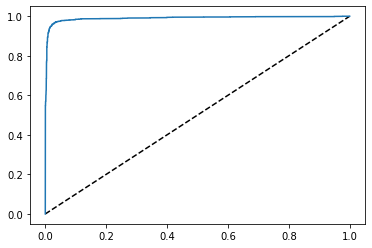

0.9901066678120929


In [22]:
fpr, tpr, _ = roc_curve(y, mnb.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

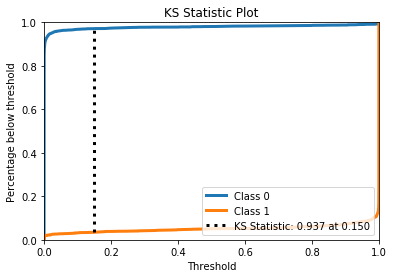

In [23]:
plot_ks_statistic(y, mnb.predict_proba(X))
plt.show()

In [24]:
confusion_matrix(y, [1 if prob >= 0.150 else 0 for prob in mnb.predict_proba(X)[:, 1]])

array([[2917,   87],
       [  79, 2246]], dtype=int64)

In [25]:
accuracy_score(y, [1 if prob >= 0.150 else 0 for prob in mnb.predict_proba(X)[:, 1]])

0.9688496903734284

In [26]:
clf = MultinomialNB()
print(cross_val_score(clf, X, y, scoring = 'roc_auc', cv=5))
# Overfitting

[0.83148158 0.86073211 0.86099333 0.84288909 0.83096416]


In [27]:
params = {'C': np.logspace(-5, 5, 30)}
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear')
clf = GridSearchCV(logit, params, cv=5, scoring = 'roc_auc').fit(X, y)
clf.best_params_, clf.best_score_

({'C': 0.6723357536499335}, 0.8401113249699481)

In [28]:
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = clf.best_params_['C']).fit(X, y)

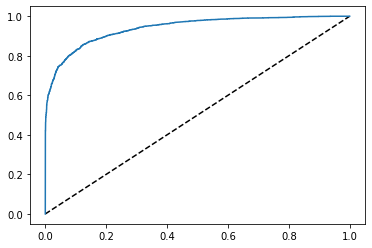

0.9399515341551767


In [29]:
fpr, tpr, _ = roc_curve(y, logit.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

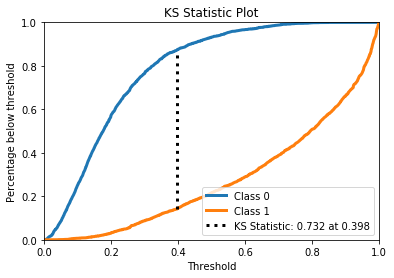

In [30]:
plot_ks_statistic(y, logit.predict_proba(X))
plt.show()

In [31]:
confusion_matrix(y, [1 if prob >= 0.398 else 0 for prob in logit.predict_proba(X)[:, 1]])

array([[2628,  376],
       [ 331, 1994]], dtype=int64)

In [32]:
accuracy_score(y, [1 if prob >= 0.398 else 0 for prob in logit.predict_proba(X)[:, 1]])

0.8673297053856258

In [33]:
clf.cv_results_
# Less overfitting

{'mean_fit_time': array([63.6580689 , 63.75281124, 63.44624853, 63.13580141, 63.14045234,
        63.30163541, 63.19797058, 63.43589029, 63.44831786, 62.73248239,
        63.32700925, 63.24023843, 62.56518993, 63.55572143, 61.92035079,
        63.34731555, 63.36733747, 61.88647432, 63.23320794, 62.18653235,
        63.51736388, 63.54001212, 61.95158839, 63.11864572, 63.41725016,
        61.83126025, 63.45739164, 62.00739594, 63.37977314, 63.1655993 ]),
 'std_fit_time': array([0.44627178, 0.70453915, 0.51008915, 0.08318639, 0.05810945,
        0.35940177, 0.23928766, 0.14139466, 0.34493324, 1.06721035,
        0.20417493, 0.28242582, 1.87069875, 0.25565254, 2.85436639,
        0.18091111, 0.08512455, 2.66785504, 0.12052106, 2.64473283,
        0.59444485, 0.58698662, 2.9759125 , 0.29215043, 0.373012  ,
        2.77687272, 0.53387502, 2.70185855, 0.15150511, 0.31766593]),
 'mean_score_time': array([6.65016074, 6.61315112, 6.60027857, 6.59437151, 6.60186787,
        6.61000113, 6.60793118

In [34]:
params = {'max_depth': [10, 20, 30, 40, 50]}
rf = RandomForestClassifier(n_estimators=100)
clf = GridSearchCV(rf, params, cv=5, scoring = 'roc_auc').fit(X, y)
clf.best_params_, clf.best_score_

({'max_depth': 50}, 0.8298054825032162)

In [35]:
rf = RandomForestClassifier(n_estimators=100, max_depth = clf.best_params_['max_depth']).fit(X, y)

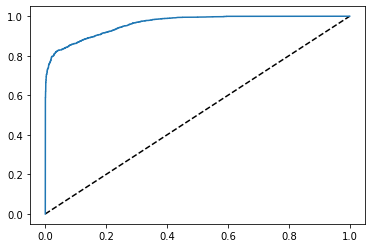

0.9623675243045116


In [36]:
fpr, tpr, _ = roc_curve(y, rf.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

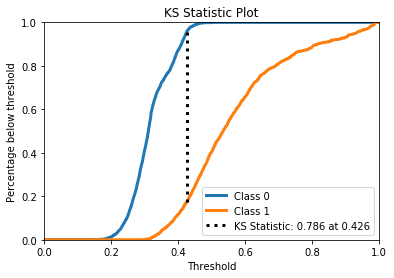

In [37]:
plot_ks_statistic(y, rf.predict_proba(X))
plt.show()

In [38]:
confusion_matrix(y, [1 if prob >= 0.426 else 0 for prob in rf.predict_proba(X)[:, 1]])

array([[2878,  126],
       [ 402, 1923]], dtype=int64)

In [39]:
accuracy_score(y, [1 if prob >= 0.426 else 0 for prob in rf.predict_proba(X)[:, 1]])

0.9009194970913867

In [40]:
clf.cv_results_
# Overfitting

{'mean_fit_time': array([47.17334518, 50.96813416, 54.90495634, 61.32255287, 66.08071647]),
 'std_fit_time': array([0.31400172, 0.29687739, 0.52758815, 2.88975031, 3.84226381]),
 'mean_score_time': array([6.83000603, 6.90028973, 6.82317219, 7.14293199, 7.13739209]),
 'std_score_time': array([0.10780377, 0.05199081, 0.04762966, 0.31474327, 0.38018853]),
 'param_max_depth': masked_array(data=[10, 20, 30, 40, 50],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 10},
  {'max_depth': 20},
  {'max_depth': 30},
  {'max_depth': 40},
  {'max_depth': 50}],
 'split0_test_score': array([0.81004956, 0.8249101 , 0.82445029, 0.82676901, 0.82640402]),
 'split1_test_score': array([0.79819119, 0.8167105 , 0.82641655, 0.82810728, 0.83983862]),
 'split2_test_score': array([0.82340007, 0.82122448, 0.8405829 , 0.83504732, 0.84247222]),
 'split3_test_score': array([0.79979425, 0.79442327, 0.82608913, 0.8235754 , 0.83470918]

In [41]:
features_logit = list(np.array(X.columns.tolist())[logit.coef_[0] != 0])
features_logit

['location_Australia',
 'location_California, USA',
 'location_Houston, TX',
 'location_NYC',
 'location_Nigeria',
 'location_Not mentioned',
 'location_Tennessee',
 'location_USA',
 'location_United States',
 'location_Worldwide',
 'location_canada',
 'keyword_Not mentioned',
 'keyword_aftershock',
 'keyword_armageddon',
 'keyword_army',
 'keyword_arsonist',
 'keyword_bioterrorism',
 'keyword_blaze',
 'keyword_blazing',
 'keyword_bleeding',
 'keyword_blight',
 'keyword_blizzard',
 'keyword_blood',
 'keyword_bloody',
 'keyword_buildings%20burning',
 'keyword_casualties',
 'keyword_catastrophe',
 'keyword_chemical%20emergency',
 'keyword_collapsed',
 'keyword_collide',
 'keyword_collided',
 'keyword_crashed',
 'keyword_crushed',
 'keyword_curfew',
 'keyword_cyclone',
 'keyword_deluge',
 'keyword_demolished',
 'keyword_demolition',
 'keyword_derailment',
 'keyword_desolate',
 'keyword_destroyed',
 'keyword_destruction',
 'keyword_detonation',
 'keyword_devastation',
 'keyword_disaster',


In [42]:
mnb_logit = MultinomialNB().fit(X[features_logit], y)

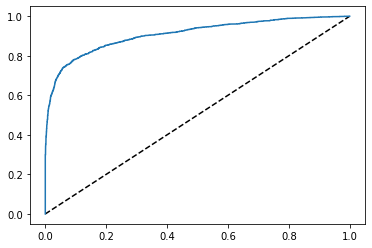

0.9087793336483256


In [43]:
fpr, tpr, _ = roc_curve(y, mnb_logit.predict_proba(X[features_logit])[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

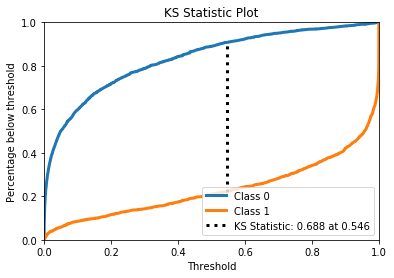

In [44]:
plot_ks_statistic(y, mnb_logit.predict_proba(X[features_logit]))
plt.show()

In [45]:
confusion_matrix(y, [1 if prob >= 0.546 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

array([[2727,  277],
       [ 513, 1812]], dtype=int64)

In [46]:
accuracy_score(y, [1 if prob >= 0.546 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

0.8517545505723401

In [49]:
clf = MultinomialNB()
print(cross_val_score(clf, X[features_logit], y, scoring = 'roc_auc', cv=5))
print(cross_val_score(clf, X[features_logit], y, scoring = 'roc_auc', cv=5).mean())

[0.86897465 0.90411858 0.89083606 0.88772834 0.86060932]
0.8824533901084812


In [50]:
pd.DataFrame({'features': X.columns,
              'Importance': rf.feature_importances_}).sort_values('Importance', ascending = False).head(20)

,features,Importance
15410,bow_rule catastrophic,0.025967
32710,bow_a9bnlse6qb,0.018755
32709,bow_corners,0.010633
33504,bow_lead http,0.010246
69477,bow_emiliorivera48 davidlabrava,0.010048
13500,bow_is fucked,0.009901
31910,bow_his guards,0.006472
57831,bow_muschamp,0.006180
37083,bow_gusts,0.006025
42689,bow_japan marked,0.005379


In [52]:
temp = pd.DataFrame({'features': X.columns,
              'Importance': rf.feature_importances_})
temp = temp.sort_values('Importance', ascending = False)
features_rf = temp.iloc[:500, 0].tolist()
features_rf

['bow_rule catastrophic',
 'bow_a9bnlse6qb',
 'bow_corners',
 'bow_lead http',
 'bow_emiliorivera48 davidlabrava',
 'bow_is fucked',
 'bow_his guards',
 'bow_muschamp',
 'bow_gusts',
 'bow_japan marked',
 'bow_fantasy stock',
 'bow_rejects against',
 'bow_mapleridge lougheed',
 'bow_hired really',
 'bow_amp ignore',
 'bow_present on',
 'bow_9e2f7bivle youtube',
 'keyword_suicide%20bombing',
 'bow_07',
 'bow_got her',
 'bow_time schedule',
 'bow_wactt18gda',
 'bow_comin soon',
 'bow_she still',
 'bow_up some',
 'bow_lookss',
 'bow_the lions',
 'bow_lopez hindsight',
 'bow_applications',
 'bow_as body',
 'bow_shantaeskyy gm',
 'bow_nws posts',
 'bow_now even',
 'bow_good lol',
 'keyword_forest%20fires',
 'bow_chloeunguyen laurensicle',
 'bow_wreckage confirmation',
 'keyword_typhoon',
 'bow_philly was',
 'bow_newport',
 'bow_stocks',
 'bow_failure rate',
 'bow_pat',
 'bow_are here',
 'bow_expanding',
 'bow_sinjar has',
 'bow_but in',
 'bow_es',
 'bow_still will',
 'bow_tneazzy mizzou',
 

In [53]:
mnb_rf = MultinomialNB().fit(X[features_rf], y)

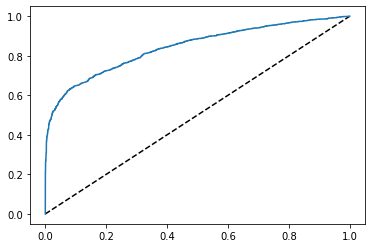

0.8432041865326518


In [54]:
fpr, tpr, _ = roc_curve(y, mnb_rf.predict_proba(X[features_rf])[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

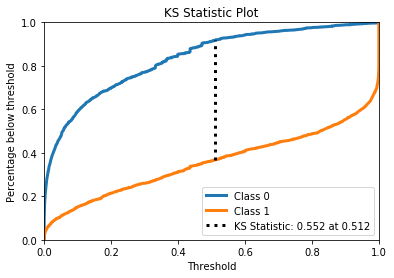

In [55]:
plot_ks_statistic(y, mnb_rf.predict_proba(X[features_rf]))
plt.show()

In [57]:
confusion_matrix(y, [1 if prob >= 0.512 else 0 for prob in mnb_rf.predict_proba(X[features_rf])[:, 1]])

array([[2761,  243],
       [ 855, 1470]], dtype=int64)

In [58]:
accuracy_score(y, [1 if prob >= 0.512 else 0 for prob in mnb_rf.predict_proba(X[features_rf])[:, 1]])

0.7939575905423156

In [59]:
clf = MultinomialNB()
print(cross_val_score(clf, X[features_rf], y, scoring = 'roc_auc', cv=5))

[0.8145868  0.83928757 0.85064677 0.84006942 0.81265771]


# Model Evaluation

In [61]:
test_X = test_bow.iloc[:, 1:]
test_y = test_bow.iloc[:, 0]

In [62]:
accuracy_score(y, [1 if prob >= 0.546 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

0.8517545505723401

In [63]:
accuracy_score(test_y, [1 if prob >= 0.546 else 0 for prob in mnb_logit.predict_proba(test_X[features_logit])[:, 1]])

0.792031523642732

In [64]:
confusion_matrix(y, [1 if prob >= 0.546 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

array([[2727,  277],
       [ 513, 1812]], dtype=int64)

In [65]:
confusion_matrix(test_y, [1 if prob >= 0.546 else 0 for prob in mnb_logit.predict_proba(test_X[features_logit])[:, 1]])

array([[1148,  190],
       [ 285,  661]], dtype=int64)

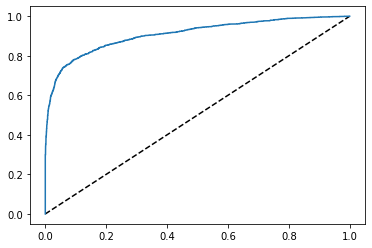

0.9087793336483256


In [66]:
fpr, tpr, _ = roc_curve(y, mnb_logit.predict_proba(X[features_logit])[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

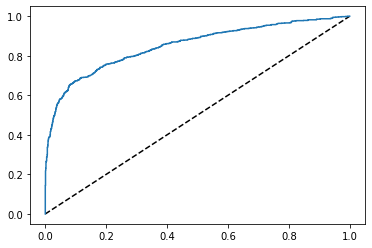

0.8510062824511673


In [67]:
fpr, tpr, _ = roc_curve(test_y, mnb_logit.predict_proba(test_X[features_logit])[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

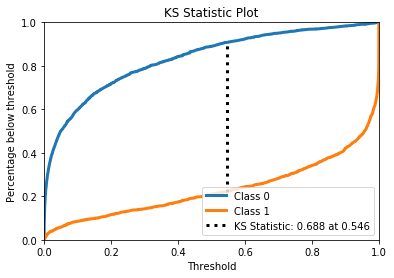

In [68]:
plot_ks_statistic(y, mnb_logit.predict_proba(X[features_logit]))
plt.show()

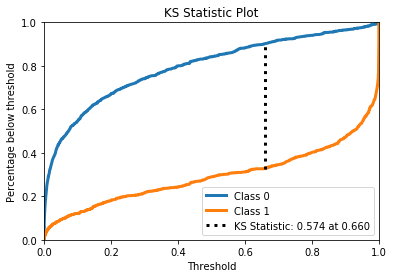

In [69]:
plot_ks_statistic(test_y, mnb_logit.predict_proba(test_X[features_logit]))
plt.show()

# Prediction

In [70]:
bow = CountVectorizer(ngram_range = (1, 2)).fit(data_rescale['text'])

In [75]:
data_rescale = add_dummy(data_rescale, onehot)
data_rescale.head()

,text,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,...,keyword_weapons,keyword_whirlwind,keyword_wild%20fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
id,,,,,,,,,,,,,,,,,,,,,
1,Our Deeds are the Reason of this #earthquake M...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Forest fire near La Ronge Sask. Canada,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,All residents asked to 'shelter in place' are ...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,"13,000 people receive #wildfires evacuation or...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Just got sent this photo from Ruby #Alaska as ...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
data_bow = add_bow(data_rescale, bow)
data_bow.head()

,target,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,location_ Alex/Mika/Leo|18|he/she/they,...,bow_reuters via,bow_via world,bow_world google,bow_google news,bow_news wall,bow_co nf4iculoje,bow_stfmbbzfb5,bow_co stfmbbzfb5,bow_ymy4rskq3d,bow_co ymy4rskq3d
id,,,,,,,,,,,,,,,,,,,,,
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
X = data_bow.iloc[:, 1:]
y = data_bow.iloc[:, 0]

In [79]:
params = {'C': np.logspace(-5, 5, 30)}
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear')
clf = GridSearchCV(logit, params, cv=5, scoring = 'roc_auc').fit(X, y)
clf.best_params_, clf.best_score_

({'C': 0.1373823795883264}, 0.7523570391806234)

In [80]:
logit = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = clf.best_params_['C']).fit(X, y)

In [81]:
features_logit = list(np.array(X.columns.tolist())[logit.coef_[0] != 0])
features_logit

['location_Not mentioned',
 'location_USA',
 'keyword_Not mentioned',
 'keyword_aftershock',
 'keyword_bioterrorism',
 'keyword_blazing',
 'keyword_blight',
 'keyword_deluge',
 'keyword_derailment',
 'keyword_evacuated',
 'keyword_famine',
 'keyword_fire',
 'keyword_hazardous',
 'keyword_heat%20wave',
 'keyword_sinkhole',
 'keyword_stretcher',
 'keyword_traumatised',
 'keyword_upheaval',
 'bow_la',
 'bow_ablaze',
 'bow_standardised the',
 'bow_pulls drunk',
 'bow_stardate',
 'bow_amp more',
 'bow_in apocalypse',
 'bow_co vwcf3slkrw',
 'bow_internet',
 'bow_remember that',
 'bow_1pdjoq4jc1',
 'bow_gordon green',
 'bow_happens',
 'bow_co fzujg7sxjg',
 'bow_amp commerce',
 'bow_standup',
 'bow_durvod',
 'bow_nose',
 'bow_up literally',
 'bow_blizzardcs please',
 'bow_sg',
 'bow_fake this',
 'bow_wait sony',
 'bow_deactivate and',
 'bow_one little',
 'bow_purse full',
 'bow_acting like',
 'bow_elutranscendent straight',
 'bow_jumpin out',
 'bow_football players',
 'bow_washable',
 'bow_kil

In [93]:
mnb_logit = MultinomialNB().fit(X[features_logit], y)

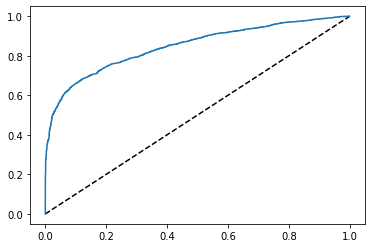

0.8474099469381909


In [95]:
fpr, tpr, _ = roc_curve(y, mnb_logit.predict_proba(X[features_logit])[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

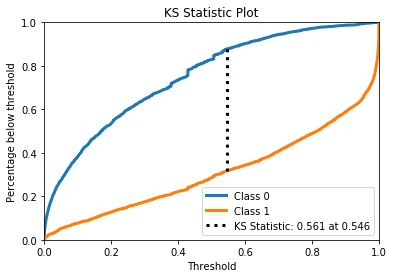

In [96]:
plot_ks_statistic(y, mnb_logit.predict_proba(X[features_logit]))
plt.show()

In [97]:
confusion_matrix(y, [1 if prob >= 0.546 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

array([[3812,  530],
       [1037, 2234]], dtype=int64)

In [98]:
accuracy_score(y, [1 if prob >= 0.546 else 0 for prob in mnb_logit.predict_proba(X[features_logit])[:, 1]])

0.7941678707474058

In [99]:
clf = MultinomialNB()
print(cross_val_score(clf, X[features_logit], y, scoring = 'roc_auc', cv=5))
print(cross_val_score(clf, X[features_logit], y, scoring = 'roc_auc', cv=5).mean())
# Overfitting

[0.75798891 0.78543565 0.80884912 0.78014681 0.86368977]
0.7992220535696768


In [100]:
predict = pd.read_csv('../../data/Disaster/test.csv', index_col = 0)
predict.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [101]:
predict['location'] = predict['location'].fillna('Not mentioned')
predict.head()

,keyword,location,text
id,,,
0,NaN,Not mentioned,Just happened a terrible car crash
2,NaN,Not mentioned,"Heard about #earthquake is different cities, s..."
3,NaN,Not mentioned,"there is a forest fire at spot pond, geese are..."
9,NaN,Not mentioned,Apocalypse lighting. #Spokane #wildfires
11,NaN,Not mentioned,Typhoon Soudelor kills 28 in China and Taiwan


In [102]:
predict['keyword'] = predict['keyword'].fillna('Not mentioned')
predict.head()

,keyword,location,text
id,,,
0,Not mentioned,Not mentioned,Just happened a terrible car crash
2,Not mentioned,Not mentioned,"Heard about #earthquake is different cities, s..."
3,Not mentioned,Not mentioned,"there is a forest fire at spot pond, geese are..."
9,Not mentioned,Not mentioned,Apocalypse lighting. #Spokane #wildfires
11,Not mentioned,Not mentioned,Typhoon Soudelor kills 28 in China and Taiwan


In [103]:
predict = add_dummy(predict, onehot)
predict.head()

,text,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,location_ Alex/Mika/Leo|18|he/she/they,...,keyword_weapons,keyword_whirlwind,keyword_wild%20fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
id,,,,,,,,,,,,,,,,,,,,,
0,Just happened a terrible car crash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Heard about #earthquake is different cities, s...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"there is a forest fire at spot pond, geese are...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Apocalypse lighting. #Spokane #wildfires,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,Typhoon Soudelor kills 28 in China and Taiwan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
predict = add_bow(predict, bow)
predict.head()

,location_,location_ Glasgow,"location_ Melbourne, Australia",location_ 45å¡ 5'12.53N 14å¡ 7'24.93E,"location_ 616 Û¢ Kentwood , MI",location_ ? ??????? ? ( ?? å¡ ? ? ? å¡),location_ ?currently writing a book?,location_ Alberta,location_ Alex/Mika/Leo|18|he/she/they,location_ Baku & Erzurum,...,bow_reuters via,bow_via world,bow_world google,bow_google news,bow_news wall,bow_co nf4iculoje,bow_stfmbbzfb5,bow_co stfmbbzfb5,bow_ymy4rskq3d,bow_co ymy4rskq3d
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
sample = pd.DataFrame(index = predict.index)
sample['target'] = [1 if prob >= 0.546 else 0 for prob in mnb_logit.predict_proba(predict[features_logit])[:, 1]]
sample.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [106]:
sample.to_csv('../../data/Disaster/submission.csv')